In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.activations import sigmoid

In [5]:
data = pd.read_csv(r"C:\Users\MANAV\Downloads\Mumbai House Prices.csv")

In [6]:
# turning Cr into Lakhs
# Define a function to apply the transformation
def adjust_price(row):
    if row['price_unit'] == 'Cr':
        return row['price'] * 100
    return row['price']

# Apply the function to the 'price' column
data['price'] = data.apply(adjust_price, axis=1)

In [7]:
data_new = data.drop(columns=['price_unit'])

In [8]:
# Removing outliers to prevent skewness of data and avoiding overfitting

Q1 = data_new['price'].quantile(0.25)
Q3 = data_new['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data_filtered = data_new[(data_new['price'] >= lower_bound) & (data_new['price'] <= upper_bound)]

In [9]:
# Calculate the mean price for each locality
mean_price_by_locality = data_filtered.groupby('locality')['price'].mean()

# Create a new column with the target encoded values
data_filtered['locality_encoded'] = data_filtered['locality'].map(mean_price_by_locality)

# Drop the original 'locality' column
data_filtered = data_filtered.drop('locality', axis=1)

C:\Users\MANAV\AppData\Local\Temp\ipykernel_2036\2772634672.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['locality_encoded'] = data_filtered['locality'].map(mean_price_by_locality)


In [10]:
categorical_cols = ['status', 'age', 'type', 'region']
data_encoded = pd.get_dummies(data_filtered, columns=categorical_cols, drop_first=True)

In [11]:
# Define features (X) and target variable (y)
X = data_encoded.drop('price', axis=1)  # All columns except 'price'
y = data_encoded['price']  # The 'price' column is the target variable

In [12]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [13]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer with a single neuron for regression
])

model.compile(optimizer='adam', loss=MeanSquaredError())

model.fit(X_train, y_train, epochs=100, verbose=0)

y_pred = model.predict(X_test)

440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [14]:
from sklearn.metrics import mean_squared_error, r2_score


mse = mean_squared_error(y_test, y_pred) # mean squared error
rmse = np.sqrt(mse) # root mean squared error
r2 = r2_score(y_test, y_pred) # r squared
n = X.shape[0]  # Number of observations
p = X.shape[1]  # Number of features
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1) # adjusted r squared

print(f"Mean Squared Error: {mse}")
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f"R^2 Score: {r2}")
print(f"adjusted R^2 Score: {adj_r2}")

Mean Squared Error: 481.798152267739
Root Mean Squared Error (RMSE): 21.94990096259523
R^2 Score: 0.9308775045361098
adjusted R^2 Score: 0.9306528697265974


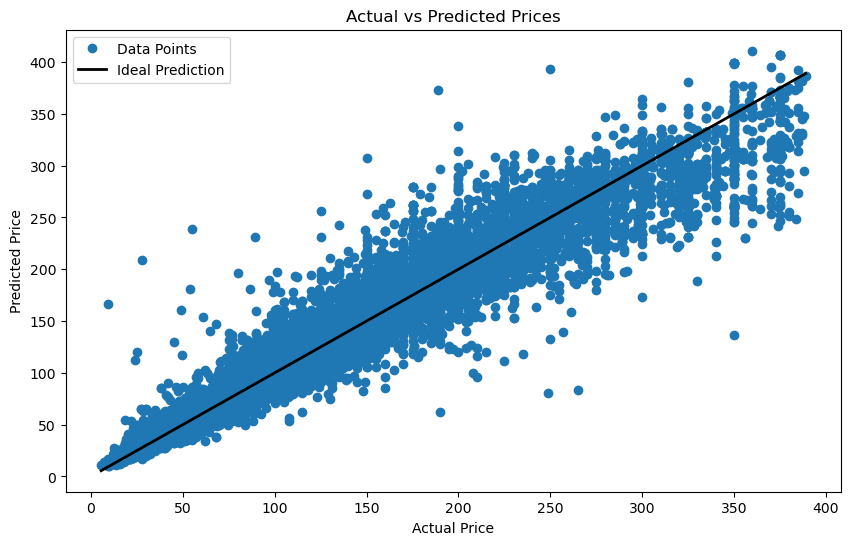

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, y_pred, 'o', label='Data Points')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k-', lw=2, label='Ideal Prediction')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.show()